# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [4]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [5]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [6]:
your_name = 'danmotp' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [7]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [8]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
12,23,male,33.36800,0,no,2009.527300
306,28,female,26.67500,2,no,22195.438243
318,44,female,26.81565,0,no,8163.314005
815,20,female,30.51620,0,no,2065.722340
157,18,male,24.41975,0,yes,17069.998275


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [9]:
num_rows = len(dataframe)
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [10]:
num_cols = len(dataframe.columns)
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [11]:
input_cols = list(dataframe.columns[:-1])
input_cols

['age', 'sex', 'bmi', 'children', 'smoker']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [12]:
type(dataframe['sex'][0])

str

In [13]:
categorical_cols = [cat for cat in dataframe.columns if type(dataframe[cat][0])==str]
print(categorical_cols)

['sex', 'smoker']


**Q: What are the column titles of output/target variable(s)?**

In [14]:
output_cols = ['charges']
print(output_cols)

['charges']


**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [15]:
minimum = dataframe['charges'].min()
maximum = dataframe['charges'].max()
average = dataframe['charges'].mean()
print([minimum, maximum, average])

[1234.06129, 70147.470811, 14689.425115448355]


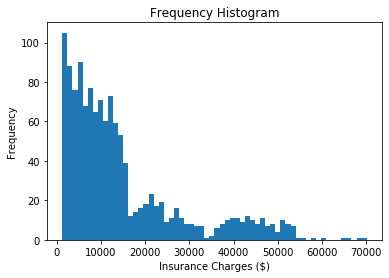

In [16]:
%matplotlib inline
plt.hist(dataframe['charges'], bins=60)
plt.gca().set(title='Frequency Histogram', xlabel = 'Insurance Charges ($)', ylabel='Frequency')
plt.show()

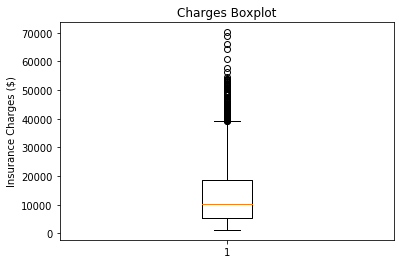

In [17]:
plt.boxplot(dataframe['charges'])
plt.gca().set(title='Charges Boxplot', ylabel='Insurance Charges ($)')
plt.show()

# Representation Analysis
If we had continued on from this point - as is, without modifications - to Step 2, and then to training at Step 4, we would not reach any result at all. Our validation loss would output "NaN" or very large values ("Inf") meaning the model was not training.

We can infer from the above graphs that we already have an obstacle to a good model. The data is highly positively skewed, most datapoints are concentrated where our target variable 'charges' is less than 15,000$. We have a high amount of outliers from 40,000 to 70,000 dollars.

We  should use the logarithm of the charges instead.

In [18]:
import numpy as np
charges = np.array(dataframe['charges'])

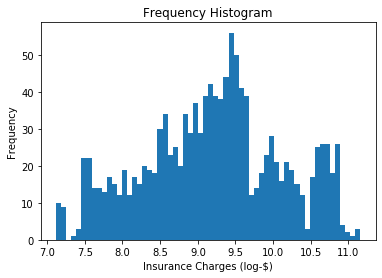

In [19]:
plt.hist(np.log(charges), bins=60)
plt.gca().set(title='Frequency Histogram', xlabel = 'Insurance Charges (log-$)', ylabel='Frequency')
plt.show()

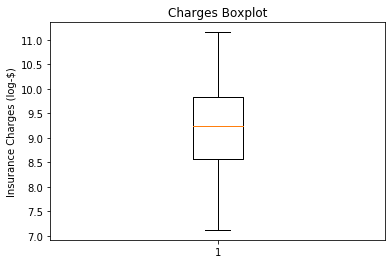

In [20]:
plt.boxplot(np.log(charges))
plt.gca().set(title='Charges Boxplot', ylabel='Insurance Charges (log-$)')
plt.show()

In [21]:
from scipy.stats import skew
skew(np.log(charges)) # From about 1.5 to -0.098 skewness coefficient

-0.0984280623307817

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [22]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "dan-motp/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/dan-motp/02-insurance-linear-regression


'https://jovian.ml/dan-motp/02-insurance-linear-regression'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [23]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [24]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[23.     ,  1.     , 33.368  ,  0.     ,  0.     ],
        [28.     ,  0.     , 26.675  ,  2.     ,  0.     ],
        [44.     ,  0.     , 26.81565,  0.     ,  0.     ],
        ...,
        [35.     ,  1.     , 35.5699 ,  1.     ,  1.     ],
        [59.     ,  0.     , 30.4095 ,  0.     ,  0.     ],
        [62.     ,  0.     , 31.97605,  3.     ,  0.     ]]),
 array([[ 2009.5273  ],
        [22195.438243],
        [ 8163.314005],
        ...,
        [43751.70393 ],
        [13884.39745 ],
        [17173.412685]]))

In [25]:
targets_array = np.log(targets_array)
targets_array

array([[ 7.6056548 ],
       [10.00764206],
       [ 9.00740549],
       ...,
       [10.68628584],
       [ 9.538521  ],
       [ 9.75111769]])

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [26]:
#inputs = torch.from_numpy(inputs_array)
#targets = torch.from_numpy(targets_array)

In [27]:
# Returned torch.float64 since arrays are float64 dtypes
#inputs.dtype, targets.dtype

In [28]:
inputs = torch.as_tensor(inputs_array, dtype=torch.float32)
targets = torch.as_tensor(targets_array, dtype=torch.float32)

In [29]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [30]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [31]:
val_percent = 0.2 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [32]:
batch_size = 30

In [33]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [34]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[63.0000,  1.0000, 21.0102,  1.0000,  0.0000],
        [20.0000,  0.0000, 23.6874,  0.0000,  1.0000],
        [37.0000,  0.0000, 29.8760,  2.0000,  0.0000],
        [18.0000,  1.0000, 36.1713,  0.0000,  0.0000],
        [59.0000,  1.0000, 26.6750,  1.0000,  0.0000],
        [53.0000,  1.0000, 30.4095,  0.0000,  0.0000],
        [49.0000,  1.0000, 35.7445,  0.0000,  0.0000],
        [30.0000,  0.0000, 41.8264,  2.0000,  0.0000],
        [43.0000,  1.0000, 29.2115,  3.0000,  0.0000],
        [19.0000,  0.0000, 39.2850,  0.0000,  0.0000],
        [47.0000,  1.0000, 46.0944,  1.0000,  0.0000],
        [24.0000,  0.0000, 24.5119,  0.0000,  0.0000],
        [30.0000,  0.0000, 27.5286,  1.0000,  1.0000],
        [34.0000,  0.0000, 36.2150,  2.0000,  0.0000],
        [42.0000,  0.0000, 36.7630,  0.0000,  0.0000],
        [38.0000,  0.0000, 29.3037,  3.0000,  0.0000],
        [64.0000,  0.0000, 31.9760,  0.0000,  0.0000],
        [55.0000,  0.0000, 28.9351,  0.0000,  0.0000],
  

Let's save our work by committing to Jovian.

In [35]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "dan-motp/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/dan-motp/02-insurance-linear-regression


'https://jovian.ml/dan-motp/02-insurance-linear-regression'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [36]:
input_size = len(input_cols)
output_size = len(output_cols)
input_size, output_size

(5, 1)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [70]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.mse_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.mse_loss(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [71]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [72]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1050,  0.3557,  0.3327,  0.4113, -0.2461]], requires_grad=True),
 Parameter containing:
 tensor([-0.3346], requires_grad=True)]

One final commit before we train the model.

In [40]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "dan-motp/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/dan-motp/02-insurance-linear-regression


'https://jovian.ml/dan-motp/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [73]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [74]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 31.036489486694336}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [125]:
model = InsuranceModel()

In [126]:
epochs = 100
lr = 1e-4
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 2.3569
Epoch [40], val_loss: 2.3517
Epoch [60], val_loss: 2.1517
Epoch [80], val_loss: 2.1298
Epoch [100], val_loss: 2.0650


In [127]:
epochs = 200
lr = 1e-4
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 2.0925
Epoch [40], val_loss: 1.9860
Epoch [60], val_loss: 2.0063
Epoch [80], val_loss: 1.9217
Epoch [100], val_loss: 1.9248
Epoch [120], val_loss: 1.9269
Epoch [140], val_loss: 1.8204
Epoch [160], val_loss: 1.8100
Epoch [180], val_loss: 1.7619
Epoch [200], val_loss: 1.7372


In [128]:
epochs = 300
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 1.8111
Epoch [40], val_loss: 1.6874
Epoch [60], val_loss: 1.6702
Epoch [80], val_loss: 1.6648
Epoch [100], val_loss: 1.6461
Epoch [120], val_loss: 1.6054
Epoch [140], val_loss: 1.5737
Epoch [160], val_loss: 1.5770
Epoch [180], val_loss: 1.5264
Epoch [200], val_loss: 1.5118
Epoch [220], val_loss: 1.5476
Epoch [240], val_loss: 1.4690
Epoch [260], val_loss: 1.4509
Epoch [280], val_loss: 1.4483
Epoch [300], val_loss: 1.4276


In [129]:
epochs = 400
lr = 1e-4
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 1.4068
Epoch [40], val_loss: 1.3891
Epoch [60], val_loss: 1.3687
Epoch [80], val_loss: 1.3545
Epoch [100], val_loss: 1.3950
Epoch [120], val_loss: 1.3250
Epoch [140], val_loss: 1.3214
Epoch [160], val_loss: 1.3063
Epoch [180], val_loss: 1.2967
Epoch [200], val_loss: 1.2897
Epoch [220], val_loss: 1.3198
Epoch [240], val_loss: 1.2497
Epoch [260], val_loss: 1.2358
Epoch [280], val_loss: 1.2548
Epoch [300], val_loss: 1.2109
Epoch [320], val_loss: 1.1992
Epoch [340], val_loss: 1.2083
Epoch [360], val_loss: 1.1780
Epoch [380], val_loss: 1.1668
Epoch [400], val_loss: 1.1573


In [130]:
epochs = 1000
lr = 1e-4
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 1.1469
Epoch [40], val_loss: 1.1389
Epoch [60], val_loss: 1.1363
Epoch [80], val_loss: 1.1346
Epoch [100], val_loss: 1.1359
Epoch [120], val_loss: 1.0993
Epoch [140], val_loss: 1.1067
Epoch [160], val_loss: 1.0810
Epoch [180], val_loss: 1.0720
Epoch [200], val_loss: 1.0706
Epoch [220], val_loss: 1.0556
Epoch [240], val_loss: 1.0758
Epoch [260], val_loss: 1.0452
Epoch [280], val_loss: 1.0315
Epoch [300], val_loss: 1.0404
Epoch [320], val_loss: 1.1198
Epoch [340], val_loss: 1.0177
Epoch [360], val_loss: 1.0031
Epoch [380], val_loss: 0.9961
Epoch [400], val_loss: 0.9931
Epoch [420], val_loss: 0.9780
Epoch [440], val_loss: 0.9828
Epoch [460], val_loss: 0.9640
Epoch [480], val_loss: 0.9923
Epoch [500], val_loss: 0.9547
Epoch [520], val_loss: 0.9460
Epoch [540], val_loss: 0.9860
Epoch [560], val_loss: 0.9406
Epoch [580], val_loss: 0.9415
Epoch [600], val_loss: 0.9297
Epoch [620], val_loss: 0.9117
Epoch [640], val_loss: 0.9059
Epoch [660], val_loss: 0.9080
Epoch [680], v

In [123]:
10**0.8080

78.6321227458418

**Q: What is the final validation loss of your model?**

In [49]:
# Before applying log(charges) - with loss = F.l1_loss(out, targets)
val_loss = 8046.5801

In [131]:
# After applying log(charges)
val_loss = 0.8080
10**val_loss

6.4268771731701975

Let's log the final validation loss to Jovian and commit the notebook

In [132]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [133]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "dan-motp/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/dan-motp/02-insurance-linear-regression


'https://jovian.ml/dan-motp/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [134]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [135]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([58.0000,  0.0000, 28.1300,  0.0000,  0.0000])
Target: tensor([9.4748])
Prediction: tensor([9.2620])


In [136]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([44.0000,  1.0000, 26.5780,  2.0000,  0.0000])
Target: tensor([9.0478])
Prediction: tensor([8.8458])


In [137]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([18.0000,  1.0000, 37.0249,  0.0000,  1.0000])
Target: tensor([10.5951])
Prediction: tensor([9.8115])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to clean up & replicate this notebook (or [this one](https://jovian.ml/aakashns/housing-linear-minimal), or [this one](https://jovian.ml/aakashns/mnist-logistic-minimal) ) for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patters in machine learning from problem-specific details.

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ml/forum/t/share-your-work-here-assignment-2/4931

In [56]:
jovian.commit(project=project_name, environment=None)
#jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "dan-motp/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/dan-motp/02-insurance-linear-regression


'https://jovian.ml/dan-motp/02-insurance-linear-regression'